In [61]:
!pip install librosa pandas tensorflow scikit-learn kaggle


In [62]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [63]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Concatenate all features
        features = np.concatenate([
            mfcc.mean(axis=1),
            chroma.mean(axis=1),
            spectral_contrast.mean(axis=1),
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(13 + 12 + 7)  # Adjusted for the number of features


In [64]:
# Paths to the CSV files
train_csv_path = os.path.join('models', 'archive', 'cv-valid-train.csv')
test_csv_path = os.path.join('models', 'archive', 'cv-valid-test.csv')

# Load the CSV files
train_df = pd.read_csv(train_csv_path).head(10000)
test_df = pd.read_csv(test_csv_path).head(2000)

In [65]:
train_audio_dir = os.path.join('models', 'archive', 'cv-valid-train')
test_audio_dir = os.path.join('models', 'archive', 'cv-valid-test')

In [66]:
# Extract features for all training audio files
train_audio_files = train_df['filename'].apply(lambda x: os.path.join(train_audio_dir, x)).tolist()
train_labels = train_df['gender'].tolist()

# Extract features for all test audio files
test_audio_files = test_df['filename'].apply(lambda x: os.path.join(test_audio_dir, x)).tolist()
test_labels = test_df['gender'].tolist()


In [67]:
# Extract features for all training audio files
print('processing the training audio files...')
train_features = [extract_features(file) for file in train_audio_files]
print('Done.')
# Extract features for all test audio files
print('processing the testing audio files')
test_features = [extract_features(file) for file in test_audio_files]
print('Done testing and training...')

processing the training audio files...
Done.
processing the testing audio files


In [68]:

# Convert labels to numerical format
encoder = LabelEncoder()
encoded_train_labels = encoder.fit_transform(train_labels)
encoded_test_labels = encoder.transform(test_labels)  # Transform using the same encoder


In [69]:
# Convert to numpy arrays for TensorFlow compatibility
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(encoded_train_labels)
y_test = np.array(encoded_test_labels)


In [70]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(encoded_train_labels)), activation='softmax')
])


/home/fareed-sayed/Documents/mp3-tone-model /venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [72]:
!pip install seaborn matplotlib

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


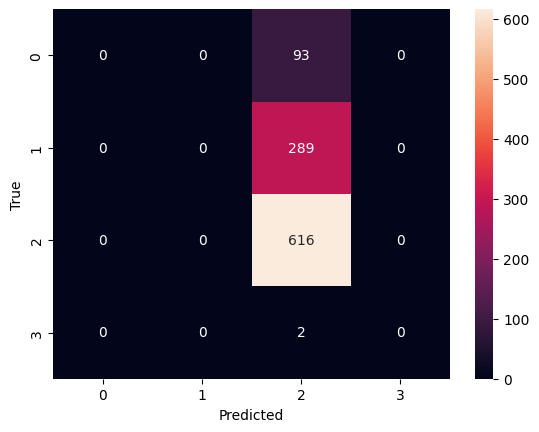

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and predictions are available
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [74]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4571 - loss: 37.1579 - val_accuracy: 0.5800 - val_loss: 1.6321
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5099 - loss: 12.2487 - val_accuracy: 0.3050 - val_loss: 2.0289
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4762 - loss: 7.6650 - val_accuracy: 0.2940 - val_loss: 1.3118
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4575 - loss: 5.1554 - val_accuracy: 0.3560 - val_loss: 1.1058
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4923 - loss: 3.8068 - val_accuracy: 0.6140 - val_loss: 0.9969
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5437 - loss: 2.9072 - val_accuracy: 0.6110 - val_loss: 0.9504
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4578 - loss: 2.5492 - val_accuracy: 0.6160 - val_loss: 0.9395
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5161 - loss: 2.0620 - val_accuracy: 0.6160 - val_los

In [75]:
def predict_tone(audio_file):
    features = extract_features(audio_file)
    features = np.expand_dims(features, axis=0)
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

In [76]:
example_audio = 'sample_audio2.ogg'  # Replace with an actual file path
print(predict_tone(example_audio))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
['nan']
